<a href="https://colab.research.google.com/github/omarjilanijidan/Iris-Cataract-Detection-From-Fundus-Images/blob/main/VGG19_without_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [27]:
# Import necessary libraries
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model


In [29]:
# Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set image size
image_size = 224

In [4]:
dataset_dir = ""

In [5]:
def create_dataset(image_category, label):
    dataset = []
    labels = []
    image_folder = os.path.join(dataset_dir, image_category)
    # Only select the images
    for img in tqdm(os.listdir(image_folder)[:1000]):
        image_path = os.path.join(image_folder, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                raise Exception("Failed to load image data")
            
            # Resize and normalize image
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0

            # Add image and label to dataset
            dataset.append(image)
            labels.append(label)
        except Exception as e:
            print(e)
    return np.array(dataset), np.array(labels)

In [6]:
# Load cataract and non-cataract datasets
cataract_images, cataract_labels = create_dataset("/content/drive/MyDrive/Papers/Dataset Fundus Image/Cataract", 1)
normal_images, normal_labels = create_dataset("/content/drive/MyDrive/Papers/Dataset Fundus Image/NDG", 0)

100%|██████████| 1000/1000 [01:16<00:00, 13.06it/s]


In [7]:
# Concatenate datasets and labels
X = np.concatenate((cataract_images, normal_images[:1000]), axis=0)
y = np.concatenate((cataract_labels, normal_labels[:1000]), axis=0)

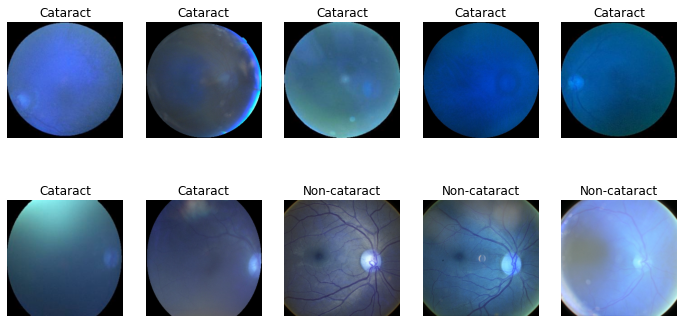

In [22]:
# Select 5 random cataract and non-cataract images
random_indices = np.random.choice(np.arange(len(y)), size=10, replace=False)
cataract_images = X[random_indices[y[random_indices] == 1]]
normal_images = X[random_indices[y[random_indices] == 0]]

# Concatenate cataract and non-cataract images
images = np.concatenate((cataract_images, normal_images))

# Create labels for cataract and non-cataract images
cataract_labels = ["Cataract" for _ in range(len(cataract_images))]
normal_labels = ["Non-cataract" for _ in range(len(normal_images))]

# Concatenate labels
labels = np.concatenate((cataract_labels, normal_labels))

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Plot images in subplots
for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img)
    ax.axis("off")
    ax.set(title=label)

plt.show()


In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Print number of images used for training and testing
print(f"Number of images used for training: {len(X_train)}")
print(f"Number of images used for testing: {len(X_test)}")

Number of images used for training: 1600
Number of images used for testing: 400


In [10]:
# Create VGG19 base model
vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3))

80134624/80134624 [==============================] - 2s 0us/step


In [11]:
# Freeze base model layers
for layer in vgg19.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Create custom model with VGG19 base and fully connected layers
inputs = vgg19.input
outputs = vgg19.output
outputs = Dropout(0.5)(outputs)
outputs = Dense(512, activation="relu")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(49, activation="sigmoid")(outputs)
outputs = GlobalAveragePooling2D()(outputs)
predictions = Dense(1, activation="sigmoid")(outputs)
model = Model(inputs=inputs, outputs=predictions)

In [13]:
# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
# Fit model on train data
history = model.fit(X_train, y_train, epochs=15, batch_size=49, validation_data=(X_test, y_test))

Epoch 1/15
33/33 [==============================] - 648s 20s/step - loss: 0.4755 - accuracy: 0.8200 - val_loss: 0.3152 - val_accuracy: 0.9025
Epoch 2/15
33/33 [==============================] - 643s 20s/step - loss: 0.2450 - accuracy: 0.9244 - val_loss: 0.1927 - val_accuracy: 0.9275
Epoch 3/15
33/33 [==============================] - 642s 20s/step - loss: 0.1888 - accuracy: 0.9419 - val_loss: 0.1598 - val_accuracy: 0.9375
Epoch 4/15
33/33 [==============================] - 642s 20s/step - loss: 0.1713 - accuracy: 0.9481 - val_loss: 0.1543 - val_accuracy: 0.9325
Epoch 5/15
33/33 [==============================] - 640s 19s/step - loss: 0.1610 - accuracy: 0.9456 - val_loss: 0.1357 - val_accuracy: 0.9650
Epoch 6/15
33/33 [==============================] - 643s 20s/step - loss: 0.1463 - accuracy: 0.9506 - val_loss: 0.1331 - val_accuracy: 0.9450
Epoch 7/15
33/33 [==============================] - 641s 20s/step - loss: 0.1434 - accuracy: 0.9488 - val_loss: 0.1328 - val_accuracy: 0.9675
Epoch 

In [15]:
print("Image size:", X_train[0].shape)

Image size: (224, 224, 3)


In [16]:
# Print maximum training accuracy
max_train_acc = max(history.history["accuracy"])
print(f"Maximum training accuracy: {max_train_acc:.4f}")

# Print maximum validation accuracy
max_val_acc = max(history.history["val_accuracy"])
print(f"Maximum validation accuracy: {max_val_acc:.4f}")

# Print minimum training loss
min_train_loss = min(history.history["loss"])
print(f"Minimum training loss: {min_train_loss:.4f}")

# Print minimum validation loss
min_val_loss = min(history.history["val_loss"])
print(f"Minimum validation loss: {min_val_loss:.4f}")


Maximum training accuracy: 0.9563
Maximum validation accuracy: 0.9700
Minimum training loss: 0.1233
Minimum validation loss: 0.1083


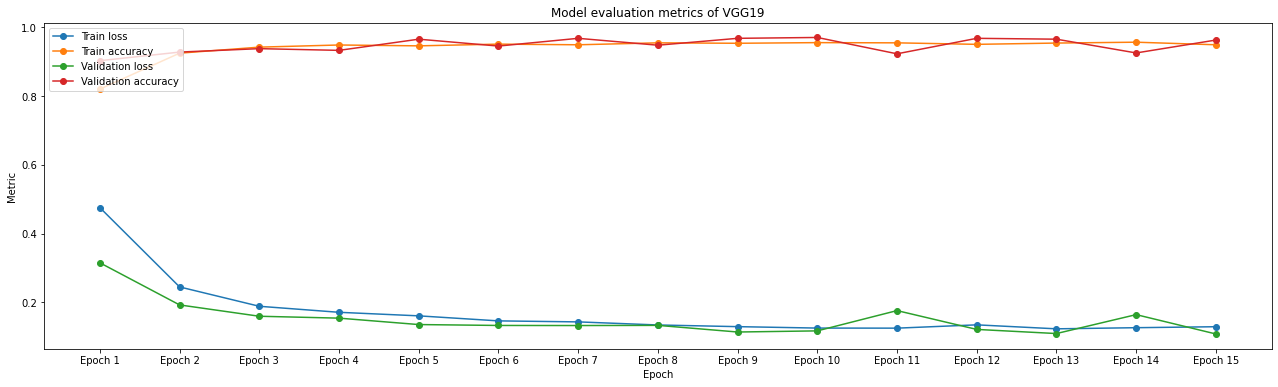

In [17]:


# Extract metric histories
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(22, 6))

# Get epoch names
epoch_names = ['Epoch {}'.format(i) for i in range(1, len(loss) + 1)]

# Plot loss, accuracy, validation loss, and validation accuracy as a combination of lines and dots over epochs
ax.plot(epoch_names, loss, '-o', label='Train loss')
ax.plot(epoch_names, acc, '-o', label='Train accuracy')
ax.plot(epoch_names, val_loss, '-o', label='Validation loss')
ax.plot(epoch_names, val_acc, '-o', label='Validation accuracy')

# Add legend and labels
ax.legend(loc='upper left')
ax.set_title('Model evaluation metrics of VGG19')
ax.set_ylabel('Metric')
ax.set_xlabel('Epoch')

plt.show()


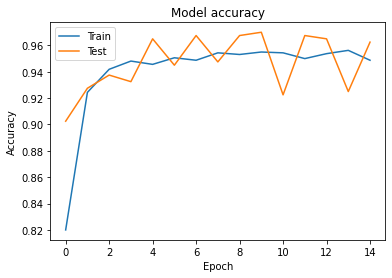

In [18]:
# Plot accuracy and loss during training
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

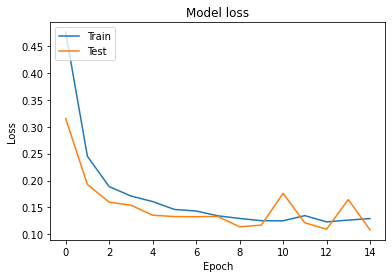

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [20]:
# Get model evaluation on test data
evaluation = model.evaluate(X_test, y_test, verbose=0)

# Print model evaluation
print(f"Test loss: {evaluation[0]}")
print(f"Test accuracy: {evaluation[1]}")


Test loss: 0.10830283910036087
Test accuracy: 0.9624999761581421


In [ ]:
from sklearn.metrics import confusion_matrix
# Make predictions on the test data
y_pred = model.predict(X_test)

# Threshold predictions to create a binary classification
y_pred = (y_pred > 0.5).astype(int)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate specificity
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
print("Specificity:", specificity)

In [23]:
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       201
           1       0.97      0.95      0.96       199

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [24]:
# Install latest version of mlxtend library
!pip install -U mlxtend


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f70ac9efcd0>)

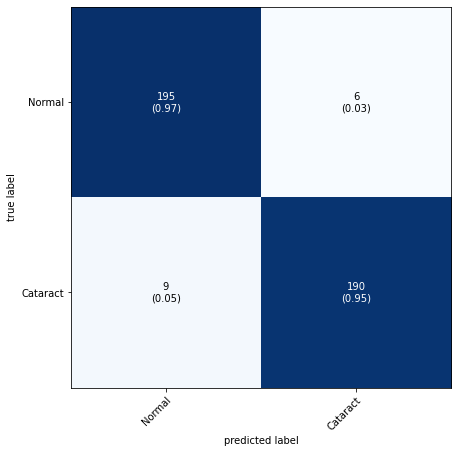

In [25]:
# Import plot_confusion_matrix function
from mlxtend.plotting import plot_confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8,7), class_names=["Normal", "Cataract"], show_normed=True)


2/2 [==============================] - 20s 6s/step


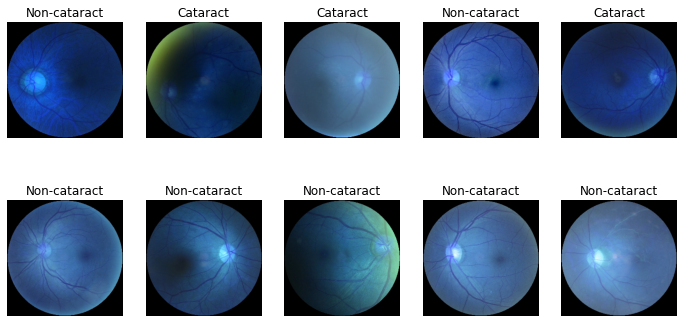

In [31]:
# Set test directory
test_dir = "/content/drive/MyDrive/Papers/Extra/preprocessed_images"

# Load test images
test_images = []
for img in os.listdir(test_dir)[:50]:
    image_path = os.path.join(test_dir, img)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0
    test_images.append(image)

# Convert test images to numpy array
test_images = np.array(test_images)

# Use model to predict labels for test images
predictions = model.predict(test_images)

# Create labels for test images
labels = ["Cataract" if prediction >= 0.5 else "Non-cataract" for prediction in predictions]

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Plot test images in subplots
for ax, img, label in zip(axs.flatten(), test_images, labels):
    ax.imshow(img)
    ax.axis("off")
    ax.set(title=label)

plt.show()

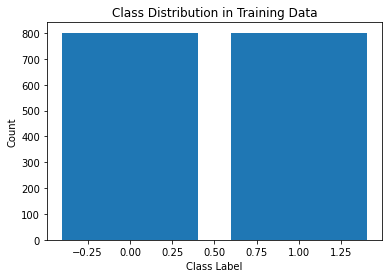

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of samples in each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot the histogram
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution in Training Data")
plt.show()
